In [1]:
import os
import pickle
from PIL import Image
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.links.caffe import CaffeFunction

from matplotlib import pylab as plt

# モデルの読み込み

In [2]:
%%time
MODEL = 'model/bvlc_googlenet.caffemodel'
PICKLE = 'model/ggnet.pkl'
if os.path.exists(PICKLE):
    print("Load pickle")
    with open(PICKLE, 'rb') as pkl:
        model = pickle.load(pkl)
else:
    print("Load caffemodel and make pickle")
    if os.path.exists(MODEL):
        model = CaffeFunction(MODEL)
        with open(PICKLE, 'wb') as pkl:
            pickle.dump(model, pkl)
    print(MODEL + " not found.")

Load pickle
CPU times: user 73.6 ms, sys: 103 ms, total: 176 ms
Wall time: 312 ms


# GoogLeNetのモデル

In [3]:
class GoogLeNet(Chain):
    insize = 224
    
    def __init__(self):
        super(GoogLeNet, self).__init__()
        with self.init_scope():
            self.conv1 =  L.Convolution2D(3, 64, 7, stride=2, pad=3)
            self.conv2_reduce = L.Convolution2D(64, 64, 1)
            self.conv2 = L.Convolution2D(64, 192, 3, stride=1, pad=1)
            self.inception_3a = L.Inception(192, 64, 96, 128, 16, 32, 32)
            self.inception_3b = L.Inception(256, 128, 128, 192, 32, 96, 64)
            self.inception_4a = L.Inception(480, 192, 96, 208, 16, 48, 64)
            self.inception_4b = L.Inception(512, 160, 112, 224, 24, 64, 64)
            self.inception_4c = L.Inception(512, 128, 128, 256, 24, 64, 64)
            self.inception_4d = L.Inception(512, 112, 144, 288, 32, 64, 64)
            self.inception_4e = L.Inception(528, 256, 160, 320, 32, 128, 128)
            self.inception_5a = L.Inception(832, 256, 160, 320, 32, 128, 128)
            self.inception_5b = L.Inception(832, 384, 192, 384, 48, 128, 128)
            loss3_fc = L.Linear(1024, 1000)
            
            loss1_conv = L.Convolution2D(512, 128, 1)
            loss1_fc1 = L.Linear(2048, 1024)
            loss1_fc2 = L.Linear(1024, 1000)
            
            loss2_conv = L.Convolution2D(528, 128, 1)
            loss2_fc1 = L.Linear(2048, 1024)
            loss2_fc2 = L.Linear(1024, 1000)
        
    def __call__(self, x, train=True):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 3, stride=2)
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.relu(self.conv2_reduce(h))
        h = F.relu(self.conv2(h))
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.max_pooling_2d(h, 3, stride=2)
        
        h = self.inception_3a(h)
        h = self.inception_3b(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_4a(h)
        
        b = F.average_pooling_2d(h, 5, stride=3)
        b = F.relu(self.loss1_conv(b))
        b = F.relu(self.loss1_fc1(b))
        b = self.loss1_fc2(b)
        
        h = self.inception_4b(h)
        h = self.inception_4c(h)
        h = self.inception_4d(h)
        
        b = F.average_pooling_2d(h, 5, stride=3)
        b = F.relu(self.loss2_conv(b))
        b = F.relu(self.loss2_fc1(b))
        b = self.loss2_fc2(b)
        
        h = self.inception_4e(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_5a(h)
        h = self.inception_5b(h)
        
        h = F.average_pooling_2d(h, 7, stride=1)
        y = self.loss3_fc(F.dropout(h, 0.4, train=train))
        return y

In [4]:
ggn = GoogLeNet()

# モデルの係数をコピーする

In [5]:
# Wとbにはそれぞれこんなのが入っている
ggn.conv1.W

variable W([[[[ 0.05909594, -0.09986343, -0.04603548, ..., -0.09589277,
                0.22298491, -0.01442515],
              [ 0.15570667, -0.01997655,  0.07419758, ..., -0.05252106,
               -0.05024625, -0.07798918],
              [ 0.06177655, -0.15446343, -0.00166107, ..., -0.04529255,
               -0.06741916,  0.08880506],
              ..., 
              [-0.09892067, -0.01140509,  0.08337764, ...,  0.21760684,
                0.04899437,  0.08849029],
              [ 0.04602221, -0.05098505, -0.11391044, ..., -0.1419754 ,
               -0.05374573,  0.07039803],
              [-0.06356351, -0.01029518, -0.07607383, ...,  0.11859852,
               -0.01197726, -0.03387409]],

             [[-0.03400929, -0.03394393, -0.03381074, ...,  0.02872139,
                0.00595249, -0.18781817],
              [-0.12311996,  0.04233423,  0.09035315, ...,  0.07497294,
                0.03957491, -0.11206054],
              [-0.12080624, -0.0058114 ,  0.05202496, ...,  0.0714

In [6]:
ggn.conv1.b

variable b([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
             0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
             0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
             0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
             0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
             0.,  0.,  0.,  0.])

## gnn に 読み込んだmodelを確認コピーする

In [7]:
# コピー先
ggn.conv1.W.shape

(64, 3, 7, 7)

In [8]:
# コピー元
model['conv1/7x7_s2'].W.shape

(64, 3, 7, 7)

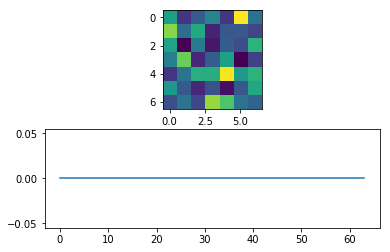

In [9]:
# 初期化しかされていない畳み込みフィルタの一つ
plt.subplot(211)
plt.imshow(ggn.conv1.W[0,0].data)

plt.subplot(212)
plt.plot(ggn.conv1.b.data)
plt.show()

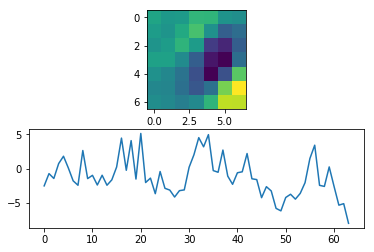

In [10]:
# 学習済の畳み込みフィルタの一つ

plt.subplot(211)
plt.imshow(model['conv1/7x7_s2'].W[0,0].data)

plt.subplot(212)
plt.plot(model['conv1/7x7_s2'].b.data)
plt.show()

In [13]:
# コピーする
ggn.conv1.W = model['conv1/7x7_s2'].W
ggn.conv1.b = model['conv1/7x7_s2'].b
ggn.conv2.W = model['conv2/3x3'].W
ggn.conv2.b = model['conv2/3x3'].b
ggn.conv2_reduce.W = model['conv2/3x3_reduce'].W
ggn.conv2_reduce.b = model['conv2/3x3_reduce'].b
ggn.inception_3a.conv1.W = model['inception_3a/1x1'].W
ggn.inception_3a.conv1.b = model['inception_3a/1x1'].b
ggn.inception_3a.conv3.W = model['inception_3a/3x3'].W
ggn.inception_3a.conv3.b = model['inception_3a/3x3'].b
ggn.inception_3a.conv5.W = model['inception_3a/5x5'].W
ggn.inception_3a.conv5.b = model['inception_3a/5x5'].b
ggn.inception_3b.conv1.W = model['inception_3b/1x1'].W
ggn.inception_3b.conv1.b = model['inception_3b/1x1'].b

# オプティマイザを定義する

In [23]:
optimizer = chainer.optimizers.AdaGrad()
optimizer.setup(ggn)

# 更新を許容するか決める

In [17]:
ggn.conv1.enable_update()

In [18]:
ggn.conv1.update_enabled

True

In [19]:
ggn.conv1.disable_update()

In [20]:
ggn.conv1.update_enabled

False